In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
#IPythonConsole.ipython_useSVG = True
import numpy as np
import pandas as pd
from tqdm import tqdm
from openbabel import pybel
RDLogger.DisableLog('rdApp.*')
from collections import defaultdict

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=False,
                          xyticks=False,
                          xyplotlabels=False,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    blanks = ['' for i in range(cf.size)]
    font_path = '/usr/share/fonts/truetype/static/Roboto-Regular.ttf'
    font_prop = font_manager.FontProperties(fname=font_path)

    try:
        font_manager.fontManager.addfont('/usr/share/fonts/truetype/static/Roboto-Bold.ttf')  
        plt.rcParams['mathtext.fontset']='cm'
        sns.set_theme(font_scale=1.20,rc={'font.family':font_manager.FontProperties(fname='/usr/share/fonts/truetype/static/Roboto-Bold.ttf').get_name()})
    except:
        pass

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            # stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
            #     accuracy,precision,recall,f1_score)
            stats_text = "Accuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}".format(
                accuracy,precision,recall)
        else:
            stats_text = "Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,
                square=True,
                annot=box_labels,
                fmt="",
                cmap=cmap,
                cbar=cbar,
                xticklabels=categories,
                yticklabels=categories,
    )

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        # sns.set(font_scale=1.10)
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:

def clean_and_standardize(smiles,ph=7.4,iso=False):
    try:
        # Convert SMILES to RDKit molecule
        mol = Chem.MolFromSmiles(smiles)
        
        # Skip invalid molecules
        if mol is None:
            return None,None

        # Canonicalize the SMILES
        # canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

        # Remove salts and other fragments / Keep only the largest fragment
        fragments = Chem.GetMolFrags(mol, asMols=True)
        largest_fragment = max(fragments, default=None, key=lambda m: m.GetNumAtoms())
        if largest_fragment is None:
            return None,None
        
        u = rdMolStandardize.Uncharger()
        uncharge_mol = u.uncharge(largest_fragment)
        uncharge_smiles = Chem.MolToSmiles(uncharge_mol, isomericSmiles=iso, canonical=True)
        
        ob_mol = pybel.readstring("smi", Chem.MolToSmiles(largest_fragment, isomericSmiles=iso, canonical=True))
        
        ob_mol.OBMol.AddHydrogens(False, True, ph)

        # Convert back to SMILES
        adjusted_smiles = ob_mol.write("smi").strip()

        return adjusted_smiles, uncharge_smiles
    
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")
        return None,None

In [4]:
def sort_dict(x):
    return {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}

def count_place(inh, parameter):
    count = {}
    for s in inh[parameter].unique():
        count[s] = sum(inh[parameter]==s)
    count = sort_dict(count)
    return count

In [5]:
df = pd.read_csv('./source/substrates_chem.csv',encoding='utf-8',sep='\t')

In [6]:
df.columns

Index(['CMPD_CHEMBLID', 'MOLREGNO', 'PARENT_CMPD_CHEMBLID', 'PARENT_MOLREGNO',
       'MOL_PREF_NAME', 'COMPOUND_KEY', 'MOLWEIGHT', 'ALOGP', 'PSA',
       'NUM_RO5_VIOLATIONS', 'CANONICAL_SMILES', 'ACTIVITY_ID',
       'STANDARD_TYPE', 'RELATION', 'STANDARD_VALUE', 'STANDARD_UNITS',
       'PCHEMBL_VALUE', 'PUBLISHED_TYPE', 'PUBLISHED_RELATION',
       'PUBLISHED_VALUE', 'PUBLISHED_UNITS', 'ACTIVITY_COMMENT',
       'DATA_VALIDITY_COMMENT', 'POTENTIAL_DUPLICATE', 'BAO_ENDPOINT',
       'UO_UNITS', 'QUDT_UNITS', 'ASSAY_ID', 'ASSAY_CHEMBLID', 'ASSAY_TYPE',
       'DESCRIPTION', 'ASSAY_SRC_ID', 'ASSAY_SRC_DESCRIPTION',
       'ASSAY_ORGANISM', 'ASSAY_STRAIN', 'ASSAY_TAX_ID', 'CURATED_BY',
       'BAO_FORMAT', 'TID', 'TARGET_CHEMBLID', 'TARGET_TYPE',
       'PROTEIN_ACCESSION', 'PREF_NAME', 'ORGANISM', 'CONFIDENCE_SCORE',
       'TARGET_MAPPING', 'APD_NAME', 'APD_CONFIDENCE', 'DOC_ID',
       'DOC_CHEMBLID', 'PUBMED_ID', 'JOURNAL', 'YEAR', 'VOLUME', 'ISSUE',
       'FIRST_PAGE', 'CELL_ID',

In [7]:
df = df[['MOL_PREF_NAME','CANONICAL_SMILES','RELATION','STANDARD_VALUE','DESCRIPTION','PUBMED_ID']].dropna(subset=['CANONICAL_SMILES','RELATION','STANDARD_VALUE','DESCRIPTION','PUBMED_ID'])

In [8]:
df['clean_smiles_pH'] = [ clean_and_standardize(s)[1] for s in df['CANONICAL_SMILES'] ]

In [9]:
source=df

In [10]:
len(df),len(df.drop_duplicates(subset=['clean_smiles_pH']))

(2520, 1236)

In [11]:
bool0 = np.array([
    'presence' not in exp and 
    'treat' not in exp and
    '5.5' not in exp and
    'inh' not in exp
    for exp in df['DESCRIPTION']
])

bool1 = np.array([
    ('Efflux' in exp or 'efflux' in exp) and 
    'Influx' not in exp 
    for exp in df['DESCRIPTION']
])

bool2 = np.array([
    'Caco2' in exp and 
    'MDCK' not in exp and
    'cell' in exp and 
    'human' in exp
    for exp in df['DESCRIPTION']
])

df = df[bool0 & bool1 & bool2]
print(len(df))

1204


In [12]:
count_place(df,'DESCRIPTION')

{'Efflux ratio of permeability from apical to basolateral over basolateral to apical side in human Caco2 cells': 138,
 'Efflux ratio of permeability in human Caco2 cells': 133,
 'Efflux ratio of permeability from basolateral to apical side over apical to basolateral side in human Caco2 cells': 94,
 'Efflux ratio of permeability from apical to basolateral side over basolateral to apical side of human Caco2 cells at 10 uM up to 120 mins by HPLC-MC analysis': 63,
 'Efflux ratio of permeability from apical to basolateral side over basolateral to apical side in human Caco2 cells': 56,
 'Efflux ratio of permeability from apical to basolateral side over basolateral to apical side in human Caco2 cells at 100 uM up to 90 mins': 46,
 'Efflux ratio of apparent permeability from basal to apical to apical to basal side of human Caco2 cells at 10 uM after 60 mins by LC/MS analysis': 40,
 'Efflux ratio of apparent permeability from basolateral to apical side over apical to basolateral side in human C

In [13]:
import copy
df_describ = copy.deepcopy(df)
df_describ['RELATION'] = [ 0 if (s=='=') else (1 if ('>' in s) else 2) for s in df_describ['RELATION'] ]
df_describ['rev'] = np.zeros(len(df_describ))

In [14]:
count_place(df_describ[df_describ['STANDARD_VALUE']<1],'STANDARD_VALUE')

{0.7: 35,
 0.8: 18,
 0.9: 18,
 0.6: 16,
 0.5: 15,
 0.1: 15,
 0.2: 15,
 0.3: 13,
 0.84: 7,
 0.48: 7,
 0.4: 7,
 0.78: 5,
 0.55: 5,
 0.42: 4,
 0.91: 4,
 0.74: 4,
 0.61: 4,
 0.36: 4,
 0.41: 4,
 0.29: 4,
 0.25: 3,
 0.47: 3,
 0.46: 3,
 0.57: 3,
 0.23: 3,
 0.26: 3,
 0.067: 2,
 0.28: 2,
 0.0: 2,
 0.092: 2,
 0.88: 2,
 0.82: 2,
 0.63: 2,
 0.89: 2,
 0.53: 2,
 0.66: 2,
 0.22: 2,
 0.49: 2,
 0.31: 2,
 0.11: 2,
 0.54: 2,
 0.37: 2,
 0.34: 2,
 0.35: 2,
 0.32: 2,
 0.97: 1,
 0.59: 1,
 0.43: 1,
 0.79: 1,
 0.94: 1,
 0.87: 1,
 0.51: 1,
 0.71: 1,
 0.95: 1,
 0.45: 1,
 0.67: 1,
 0.72: 1,
 0.33: 1,
 0.21: 1,
 0.39: 1,
 0.77: 1,
 0.73: 1}

In [15]:
val_list = []
rel_list = []
for i in range(len(df_describ)):
    data = df_describ.iloc[i]
    rel_list.append(data['RELATION'])
    val_list.append(data['STANDARD_VALUE'])
        
df_describ['RELATION']=rel_list
df_describ['STANDARD_VALUE']=val_list

In [16]:
data_list = []
tho1=2.0
tho2=2.0
for i in range(len(df_describ)):
    data = df_describ.iloc[i]
    val = data['STANDARD_VALUE']
    rel =  data['RELATION']

    if (rel==2 and val <= tho1):
        data_list.append(0)
    elif (rel==1 and val >= tho2):
        data_list.append(2)
    elif (rel==1 or rel==2):
        data_list.append(None)
    elif val<tho1:
        data_list.append(0)
    elif val>=tho1 and val<tho2:
        data_list.append(1)
    else:
        data_list.append(2)
        
df_describ['label']=data_list
print(len(set(df_describ['clean_smiles_pH'])),len(df_describ))
df_describ = df_describ.dropna(subset=['label'])


727 1204


In [17]:
count_place(df_describ,'label')

{2.0: 711, 0.0: 476}

In [18]:
# df_describ['label']=[ True if s==2 else (None if s==1 else False) for s in df_describ['label'].tolist()]
# df_describ=df_describ.dropna(subset=['label'])

In [19]:
count_place(df_describ,'label')

{2.0: 711, 0.0: 476}

In [20]:
def test_v1(data_dict,dropna=True,strict=True):
    from scipy.stats import chisquare,multinomial
    val_list = []
    for smi in data_dict.keys():
        
        temp = np.array(data_dict[smi])
        total=len(temp)
        
        results=np.zeros(3)
        for l in range(3):
            results[l]=sum(temp==l)
        
        observed=np.zeros(2)
        observed[0]=sum(temp<=0)
        observed[1]=sum(temp>=1)
        
        if strict:
            if results[results.argmax()]==total:
                val_list.append(results.argmax())
            else:
                val_list.append(None)
        else:
            if observed[observed.argmax()]==total:
                if results.argmax()==0 and results[0]==results[1]:
                        val_list.append(1)
                else:
                    val_list.append(results.argmax())
            else:
                val_list.append(None)
    if dropna:
        return [(k,v) for k,v in zip(data_dict.keys(),val_list) if v is not None]
    else:
        return [(k,v) for k,v in zip(data_dict.keys(),val_list) ]
    

In [21]:
df_describ['clean_smiles_pH'] = [ clean_and_standardize(s)[1] for s in df_describ['CANONICAL_SMILES'] ]
data_dict = defaultdict(list)
smiles_dict = defaultdict(list)
for i in range(len(df_describ)):
    data = df_describ.iloc[i]
    smiles = data['clean_smiles_pH']
    smiles_dict[smiles].append(i)
    data_dict[smiles].append(data['label'])

val_list = []
for k,v in test_v1(data_dict,dropna=False,strict=False):
    val_list.append(v)
        
smiles = list(data_dict.keys())
df_process = pd.DataFrame({'smiles':smiles,'label':val_list}).dropna()

In [22]:
len(df_process),count_place(df_process,'label')

(708, {2.0: 415, 0.0: 293})

In [23]:
df_process['label']=[ True if s==2 else (None if s==1 else False) for s in df_process['label'].tolist()]
df_process=df_process.dropna(subset=['label'])

In [24]:
len(df_process),count_place(df_process,'label')

(708, {True: 415, False: 293})

In [25]:
df_process.to_csv('./substrates_refine.csv',index=False)

In [26]:
labels = ['TN','FP','FN','TP']
categories = ['', '']
def show_confict(df_process,df_vivo,drop=False):
    data_dict = defaultdict(list)
    smiles_dict = defaultdict(list)
    for i in range(len(df_process)):
        data = df_process.iloc[i]
        smiles = data['smiles']
        try:
            smiles_dict[smiles].append(data['drug'])
        except:
            pass
        val = data['label']
        data_dict[smiles].append(val)

    for i in range(len(df_vivo)):
        data = df_vivo.iloc[i]
        smiles = data['smiles']
        try:
            smiles_dict[smiles].append(data['drug'])
        except:
            pass
        val = data['label']
        data_dict[smiles].append(val)

    label_list=[]
    truth_list=[]
    for v in data_dict.values():
        if len(v)==2:
            label_list.append(v[0])
            truth_list.append(v[1])
        # else:
        #     label_list.append(None)
        #     truth_list.append(None)

    return confusion_matrix(truth_list,label_list)

In [27]:
sub_com= pd.read_csv('../data_extra/competitive.csv')

In [28]:
sub_com= pd.read_csv('../data_extra/competitive.csv')
sub_com['groundTruth']=[True,True,None,True,True,True,True,None,False,True,None,True,True]

In [29]:
sub_com

,drug,smiles,groundTruth
0,Morphine,CN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5,True
1,Vinblastine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,True
2,Nicardipine,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,None
3,Hoechst_33342,CCOc1ccc(-c2nc3ccc(-c4nc5ccc(N6CCN(C)CC6)cc5[n...,True
4,Paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,True
5,Rhodamine_123,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12,True
6,Verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,True
7,Tariquidar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cc(OC)c(OC)c...,None
8,Valproic_acid,CCCC(CCC)C(=O)O,False
9,Colchicine,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1C(NC(C)=O...,True


In [30]:
from copy import deepcopy
def validation(df_process,inh_com,dropna=True):
    smi_mask=list(inh_com['smiles'])
    drug_dict={}
    turth_dict={}
    for i,smi in enumerate(smi_mask):
        drug_dict[smi]=inh_com.iloc[i]['drug']
        turth_dict[smi]=inh_com.iloc[i]['groundTruth']
    flag=[ exp in smi_mask for exp in df_process['smiles'] ]
    df=deepcopy(df_process[flag])
    df['drug']=list([ drug_dict[smi] for smi in df['smiles'] ])
    df['groundTruth']=list([ turth_dict[smi] for smi in df['smiles'] ])
    df=df[['drug','smiles','label','groundTruth']]
    if dropna:
        df=df.dropna()
    return df

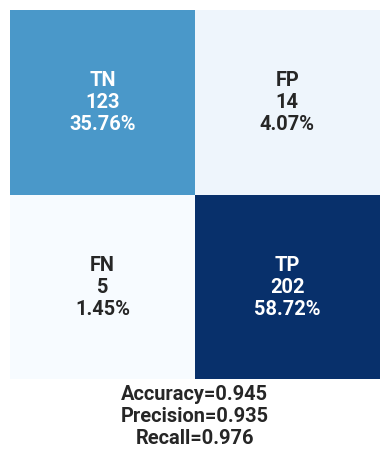

In [31]:
cf=show_confict(pd.read_csv('../data_classes/substrates_classes.csv'),df_process)
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
plt.savefig('../../../image/'+'subLow2High.png',bbox_inches='tight',transparent=True,)
plt.show()
print()

In [32]:
pd.read_csv('../data_classes/substrates_classes.csv')

,smiles,label
0,Cc1c(F)c(N2CCNC(C)C2)cc2c1c(=O)c(C(=O)O)cn2C1CC1,True
1,COc1cc(C=CC(=O)CC(=O)C=Cc2ccc(O)c(OC)c2)ccc1O,False
2,O=Cc1cc(O)ccc1Br,False
3,CC(=O)OC1=CC(n2cc(F)c(=O)[nH]c2=O)OC(C)C1=O,False
4,c1ccc(P(c2ccccc2)c2ccccc2)cc1,True
...,...,...
3098,CCN(CC)C(O)=Nc1ccc(OCC(O)CNC(C)(C)C)c(C(C)=O)c1,True
3099,C=C1CC2C3CCC4=C=C(O)C#CC4(C)C3(F)C(=O)CC2(C)C1...,True
3100,CCC(C)C(C(CC(=O)N1CCCC1C(OC)C(C)C(O)=NC(Cc1ccc...,True
3101,CC(C)CC1N=C(O)C(C)N(C)C(=O)CN=C(O)C(=Cc2ccccc2...,True


In [33]:
High=validation(df_process,sub_com,dropna=False)

In [34]:
Low=validation(pd.read_csv('../data_classes/substrates_classes.csv'),sub_com,dropna=False)

In [35]:
Low

,drug,smiles,label,groundTruth
271,Doxorubicin,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=...,True,True
321,Vinblastine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,True,True
527,Daunorubicin,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(C...,True,True
616,Rhodamine_123,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12,True,True
660,Nicardipine,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,False,None
713,Colchicine,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1C(NC(C)=O...,True,True
714,Morphine,CN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5,True,True
721,Paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,True,True
745,Elacridar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cccc4c(=O)c5...,False,None
962,Verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,True,True


In [36]:
High

,drug,smiles,label,groundTruth
248,Tariquidar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cc(OC)c(OC)c...,True,None
302,Paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,True,True
667,Daunorubicin,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(C...,True,True
675,Nicardipine,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,False,None
704,Vinblastine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,True,True
705,Colchicine,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1C(NC(C)=O...,True,True


In [37]:
Gmatrix=pd.merge(Low, High, on=['smiles','drug','groundTruth'],how='outer')[['drug','smiles','groundTruth','label_x','label_y']]
Gmatrix['label_noisy']=Gmatrix['label_x']
Gmatrix['label_refined']=Gmatrix['label_y']
Gmatrix=Gmatrix.drop(['label_x','label_y'],axis=1)

In [38]:
Gmatrix.to_csv('Matrix.csv',index=False)